# Reprojecting GOES JPG and PNG Images to Mercator and Lambert Conformal Conic in Python with GDAL
**Lance Berc**

2019-12-03

## Synopsis
Imagery from NASA/NOAA weather satellites is readily available from many sources, but the raw data is more useful when reprojected from the satellite's viewpoint to a more familiar map projection centering on a specific area of interest.

Mercator is a common projection used for ship's navagational charts and grammar school wall maps. It also allows overlaying raster weather charts available from NOAA's Ocean Prediction Center.

Georeferencing parameters (for mapping the image to Earth coordinates) are derived from data published by NASA. Much scientific satellite imagery comes in GeoTIFF or NetCDF format containing this information but it isn't present in our simple JPG and PNG images.

This code handles GOES Full Disk and CONUS sectors. GOES satellites in Mode 6 (the current operational mode) can also produce images for two mesoscale regions. The same reprojection principles apply to these regions if one knows the scan angle to the image's upper-left corner.

## References
NASA's GOES Product Users Guide. Projection is defined in section 5.1.2.7.

https://www.goes-r.gov/users/docs/PUG-L1b-vol3.pdf

Meteosat projection is defined in section 4.4.3.2 of

https://www.cgms-info.org/documents/cgms-lrit-hrit-global-specification-(v2-8-of-30-oct-2013).pdf

https://www.cgms-info.org/documents/pdf_cgmf_03.pdf (older version)

#### Additional Python Packages and Libraries
https://numpy.org - Very slick base array handling

https://www.osgeo.org/ - The Open Source Geospatial Foundation.

https://gdal.org/ - The Geospatial Data Abstraction Library

https://proj.org/ - Georaphic projections and conversions

https://matplotlib.org - From John Hunter - interesting backstory

https://scitools.org.uk/cartopy/docs/latest/ - Started by the UK Met Office

Getting versions of the packages that work together can be an issue. One solution is to use [Anaconda](https://www.anaconda.com/distribution/) + virtual environments. For MacOS I used the [GDAL complete bundle from KyngChaos](http://www.kyngchaos.com/software/frameworks) which contains compatible versions of GDAL, GEOS, and Proj. My Windows7 environment isn't so clean - YMMV.

#### Background
Many of the projection's are defined in the EPSG's Well Known Text (WKT) format:

https://www.epsg.org

NASA and EUMETSAT publish great reference material; it can be a bit dense:

https://www.goes-r.gov/resources/docs.html

https://www.eumetsat.int/website/home/Data/TechnicalDocuments/index.html

##### Nota Bene
This example reprojects a raster image into another raster image using GDAL; it's also possible to do this with Matplotlib+Cartopy. [Using matplotlib+cartopy](GOES_Cartopy.ipynb) with `pcolormesh()` to reproject a 5000x3000 1k CONUS image took 37 seconds on my home machine - in a loop processing multiple images it occupies all 8GB of RAM; with GDAL a similar operation took about a second and has a working set less than 500MB. GDAL can process a GOES 5424x5424 2k full-disk image in under 6 seconds - I haven't waited for `pcolormesh` to finish.

## Example 1 - GOES-17 CONUS (PACUS)
Reproject a GOES-17 CONUS (PACUS) 1k image (5000x3000) to Mercator.
### Raw GOES-17 CONUS (PACUS) Input
![input image](./GOES-17_CONUS.jpg)

In [1]:
#!/usr/bin/python
import numpy as np
from PIL import Image
from osgeo import gdal

Orbit and perspective definitions for GOES satellites from NASA's Product Users Guide. The per-resolution items contain the scan angle, raster size, and positioning of the upper-left corner. "1k" and "2k" represent the per-pixel resolutions of the images. There are both higher- (".5k") and lower ("4k" and "10k") resolutions defined for various instruments.

In [2]:
goes16 = { # GOES-16, aka GOES-R, GOES-EAST
    "p_height": 35786023.0,           # perspective height from the ellipsoid
    "height": 42164160.0,             # from center of the earth
    "longitude": -75.0,
    "sweep_axis": 'x',
    "semi_major": 6378137.0,          # GRS-80 ellipsoid
    "semi_minor": 6356752.31414,      # GRS-80 ellipsoid
    "flattening": 298.257222096,
    "eccentricity": 0.0818191910435,
    # The other resolution (.5k, 4k, etc) can be added here
    "1k": {
        "resolution": 0.000028,       # radians per pixel
        "FD": {
            "x_offset": -0.151858,    # radians from nadir
            "y_offset":  0.151858,
            "shape": (10848, 10848),  # pixels in image
        },
        "CONUS": {
            "x_offset": -0.101346,
            "y_offset":  0.128226,
            "shape": (5000, 3000),
        }
    },
    "2k": {
        "resolution": 0.000056,
        "FD": {
            "x_offset": -0.151844,
            "y_offset":  0.151844,
            "shape": (5424, 5424),
        },
        "CONUS": {
            "x_offset": -0.101332,
            "y_offset":  0.128212,
            "shape": (2500, 1500),
        }
    }
}

goes17 = { # GOES-17, aka GOES-S, GOES-WEST
    "p_height": 35786023.0,
    "height": 42164160.0,
    "longitude": -137.0,
    "sweep_axis": 'x',
    "semi_major": 6378137.0,
    "semi_minor": 6356752.31414,
    "flattening": 298.257222096,
    "eccentricity": 0.0818191910435,
    "1k": {
        "resolution": 0.000028,
        "FD": {
            "x_offset": -0.151858,
            "y_offset":  0.151858,
            "shape": (10848, 10848),
        },
        "CONUS": { # aka PACUS because it's mostly Pacific Ocean
            "x_offset": -0.069986,
            "y_offset":  0.128226,
            "shape": (5000, 3000),
        }
    },
    "2k": {
        "resolution": 0.000056,
        "FD": {
            "x_offset": -0.151844,
            "y_offset":  0.151844,
            "shape": (5424, 5424),
        },
        "CONUS": {
            "x_offset": -0.069972,
            "y_offset":  0.128212,
            "shape": (2500, 1500),
        }
    },
}

The EPSG definition of Mercator doesn't allow longitudes that extend
past -180 or 180 which makes working in the Pacific difficult. Define
our own centralized on the anti-meridian to make working with GOES-17
(which crosses the anti-meridian) continuous.

In [3]:
proj_mercator =      "+proj=merc +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +over"
proj_anti_mercator = "+proj=merc +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +over +lon_0=-180"

Define the source and destination files and the output dimensions and coverage area.
This interest area isn't exactly "square" wrt Mercator, but is close.

In [4]:
sourcefn = "./GOES-17_CONUS.jpg"
destfn = "./GOES-17_Mercator.jpg"
(w, h) = (1280, 720) # 16:9 aspect ratio HD-sized (not FullHD which is 1920x1280)
interestArea = [-152.0, 30.0, -110.0, 50.0] # lat/long of ll, ur corners

#### GDAL affine geotransformation.

Raster location through geotransform (affine) array `[upperleftx, scalex, skewx, upperlefty, skewy, scaley]`

`upperleftx`, `upperlefty`: distance from center (satellite nadir) in meters

`scalex`, `scaley`: size of one pixel of raster projection in meters

`skewx`, `skewy` are zero because the images are not rotated wrt the equator

scaley is negative because scan GOES order is from top (positive) towards bottom (negative). This might be different for other satellite families.

In [5]:
s = goes17
res = s["1k"]
sector = res["CONUS"]
upper_left_x = sector['x_offset'] * s['p_height']
upper_left_y = sector['y_offset'] * s['p_height']
resolution_m = res['resolution'] * s['p_height']

geotransform = [upper_left_x, resolution_m, 0, upper_left_y, 0, -resolution_m]

#### Proj and EPSG WKT definitions, GDAL Warp Options
Geosynchronous satellite projection (`geos`) in both Proj and EPSG WKT (Well Known Text) formats using specs from the NASA Product Users Guide instead of the default Proj values for `geos`.

GDAL creates a "sidecar file" when the source file doesn't contain georeferencing information. GDAL documentation states that this can be prevented by setting "GDAL_PAM_ENABLE=NO" in the warpOptions but this doesn't seem to work (neither does FALSE). The warp option SOURCE_EXTRA is about what to do when the projection is off-earth. Turning on multithreading doesn't seem to improve speed on my quad-core Windows7 setup.

In [6]:
proj = "+proj=geos +lon_0=%f +h=%f +a=%f +b=%f +f=%f +units=m +no_defs -ellps=GRS80 +sweep=%s +over" % (
    s['longitude'],
    s['p_height'],
    s['semi_major'],
    s['semi_minor'],
    1/s['flattening'], # Inverse flattening
    s['sweep_axis'])
WKT = 'PROJCS["unnamed",GEOGCS["unnamed ellipse",DATUM["unknown",SPHEROID["unnamed",%f,%f]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]]\
,PROJECTION["Geostationary_Satellite"],PARAMETER["central_meridian",%f],PARAMETER["satellite_height",%f],PARAMETER["false_easting",0],PARAMETER["fal\
se_northing",0],UNIT["Meter",1],EXTENSION["PROJ4","%s"]]' % (s['semi_major'], s['flattening'], s['longitude'], s['p_height'], proj)

warpOptions = gdal.WarpOptions(
    format="MEM",
    width=w,
    height=h,
    outputBoundsSRS="EPSG:4326", # WGS84 - Allows use of lat/lon outputBounds
    outputBounds=interestArea,
    dstSRS=proj_anti_mercator, # GOES-17 full-disk crosses the anti-meridian
    warpOptions=["SOURCE_EXTRA=500"], # Magic from The Internet for off-earth pixels
    multithread = True, # Not sure if this buys anything on my setup
)

Do the warp, convert to a PIL image then clean up.

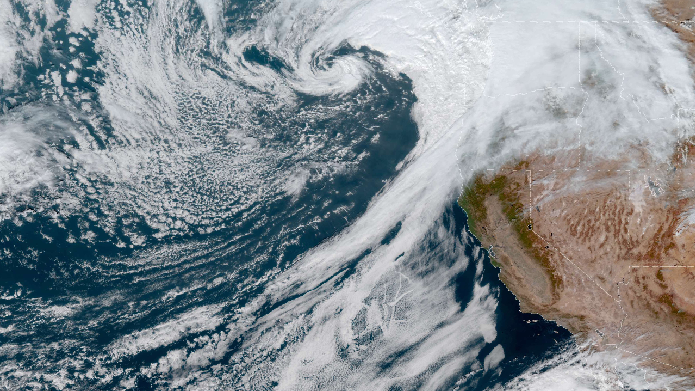

In [7]:
src = gdal.Open(sourcefn, gdal.GA_ReadOnly) # A raw PNG or JPG
src.SetProjection(WKT)            # Projection and Georeferencing (from satellite longitude)
src.SetGeoTransform(geotransform) # Geotransform - scan angle and pixel width

dst = gdal.Warp('', src, options=warpOptions)
if not dst:
    print("Warp failed %s" % (fn))
    img = None
else:
    dsta = dst.ReadAsArray()          # Array shape is [band, row, col]
    arr = dsta.transpose(1, 2, 0)     # Virtually change the shape to [row, col, band]
    img = Image.fromarray(arr, 'RGB') # Convert to PIL image
    #img.save(destfn, "JPEG")
    
    # This section is just to show the image in jupyter
    %matplotlib inline
    import matplotlib
    
    dpi = 100
    w, h = (1280/dpi, 720/dpi)
    matplotlib.rcParams['savefig.pad_inches'] = 0
    matplotlib.rcParams['savefig.bbox'] = "tight"
    
    fig = matplotlib.pyplot.figure(frameon=False) # Setting size here doesn't work right
    fig.set_size_inches(w, h)                     # Set size here instead
    ax = matplotlib.pyplot.axes(frameon=False)
    ax.axis('off')
    
    matplotlib.pyplot.imshow(img)
    matplotlib.pyplot.show()

# Clean up - this is important if running in a loop
src = None
dst = None
dsta = None
arr = None

# A side effect of setting dst to None is that the sidecar is emitted when dst is "closed"
#import os
#sidecar = "%s.aux.xml" % (sourcefn)
#if os.path.isfile(sidecar): # Would be neat to figure out how to supress sidecar emission
#    os.unlink(sidecar)

An early season storm raining on Washington and Oregon.

### GOES-17 CONUS (PACUS) Output
![mercator image](./GOES-17_MERCATOR.jpg)

## Example 2 - GOES-16 Full Disk
The same as above, but with GOES-16 Full Disk input at 2k resolution.
### Raw GOES-16 Full Disk Input
![GOES-16_Full_Disk image](./GOES-16_FD.jpg)

In [8]:
sourcefn = "./GOES-16_FD.jpg"
destfn = "./GOES-16_Mercator.jpg"
(w, h) = (1280, 720) # 16:9 aspect ratio HD-sized (not FullHD which is 1920x1280)
interestArea = [-90, 18.5, -57, 35] # lat/long of ll, ur corners
s = goes16
res = s["2k"]
sector = res["FD"]

Everything else is the same as the above example except the output uses `proj_mercator`.

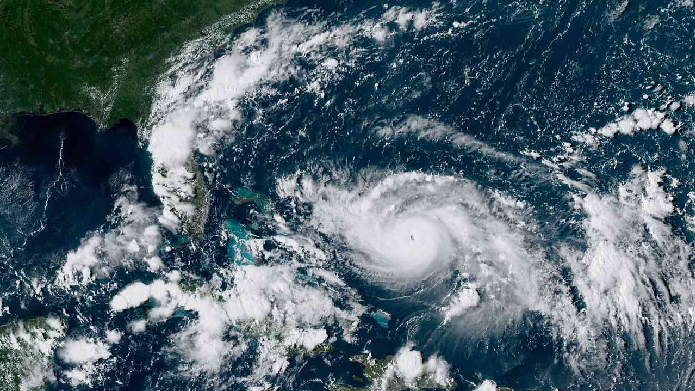

In [9]:
upper_left_x = sector['x_offset'] * s['p_height']
upper_left_y = sector['y_offset'] * s['p_height']
resolution_m = res['resolution'] * s['p_height']

geotransform = [upper_left_x, resolution_m, 0, upper_left_y, 0, -resolution_m]
proj = "+proj=geos +lon_0=%f +h=%f +a=%f +b=%f +f=%f +units=m +no_defs -ellps=GRS80 +sweep=%s +over" % (
    s['longitude'],
    s['p_height'],
    s['semi_major'],
    s['semi_minor'],
    1/s['flattening'], # Inverese flattening
    s['sweep_axis'])
WKT = 'PROJCS["unnamed",GEOGCS["unnamed ellipse",DATUM["unknown",SPHEROID["unnamed",%f,%f]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]]\
,PROJECTION["Geostationary_Satellite"],PARAMETER["central_meridian",%f],PARAMETER["satellite_height",%f],PARAMETER["false_easting",0],PARAMETER["fal\
se_northing",0],UNIT["Meter",1],EXTENSION["PROJ4","%s"]]' % (s['semi_major'], s['flattening'], s['longitude'], s['p_height'], proj)

warpOptions = gdal.WarpOptions(
    format="MEM",
    width=w,
    height=h,
    outputBoundsSRS="EPSG:4326", # WGS84 - Allows use of lat/lon outputBounds
    outputBounds=interestArea,
    dstSRS=proj_mercator,
    warpOptions=["SOURCE_EXTRA=500"], # Magic from The Internet
    multithread = True, # Not sure if this buys anything on my setup
)
src = gdal.Open(sourcefn, gdal.GA_ReadOnly)
src.SetProjection(WKT)            # Projection and Georeferencing (from satellite longitude)
src.SetGeoTransform(geotransform) # Scan angle and pixel width

dst = gdal.Warp('', src, options=warpOptions)
if not dst:
    print("Warp failed %s" % (fn))
    img = None
else:
    dsta = dst.ReadAsArray()          # Array shape is [band, row, col]
    arr = dsta.transpose(1, 2, 0)     # Virtually change the shape to [row, col, band]
    img = Image.fromarray(arr, 'RGB') # Convert to PIL image
    #img.save(destfn, "JPEG")
   
    # This section is just to show the image in jupyter
    %matplotlib inline
    import matplotlib
    
    dpi = 100
    w, h = (1280/dpi, 720/dpi)
    matplotlib.rcParams['savefig.pad_inches'] = 0
    matplotlib.rcParams['savefig.bbox'] = "tight"
    
    fig = matplotlib.pyplot.figure(frameon=False) # Setting size here doesn't work right
    fig.set_size_inches(w, h)
    ax = matplotlib.pyplot.axes(frameon=False)
    ax.axis('off')
    
    matplotlib.pyplot.imshow(img)
    matplotlib.pyplot.show()

# Clean up - important if running in a loop
src = None
dst = None
dsta = None
arr = None

# A side effect of setting dst to None is that the sidecar is emmitted when dst is "closed"
#import os
#sidecar = "%s.aux.xml" % (sourcefn)
#if os.path.isfile(sidecar): # Would be neat to figure out how to supress sidecar emission
#    os.unlink(sidecar)

Hurricane Dorian giving the Carribbean a wallop.
### GOES-16 Full Disk Output
![mercator image](./GOES-16_MERCATOR.jpg)

## Example 3 - GOES-16 Full Disk - Lambert Conformal Conic
Same GOES-16 Full Disk input image as above, but reprojected to Lambert Conformal Conic using standard United States parameters.

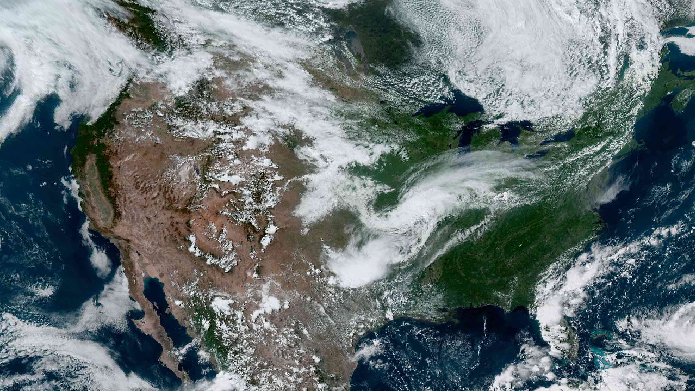

In [10]:
proj_lcc = "+proj=lcc +lon_0=-96 +lat_0=38 +lat_1=33 +lat_2=45"
sourcefn = "./GOES-16_FD.jpg"
destfn = "./GOES-16_LCC.jpg"
(w, h) = (1280, 720) # 16:9 aspect ratio HD-sized (not FullHD which is 1920x1280)
interestArea = [-123, 20.0, -59, 52.0] # lat/long of ll, ur corners
s = goes16
res = s["2k"]
sector = res["FD"]
upper_left_x = sector['x_offset'] * s['p_height']
upper_left_y = sector['y_offset'] * s['p_height']
resolution_m = res['resolution'] * s['p_height']

geotransform = [upper_left_x, resolution_m, 0, upper_left_y, 0, -resolution_m]
proj = "+proj=geos +lon_0=%f +h=%f +a=%f +b=%f +f=%f +units=m +no_defs -ellps=GRS80 +sweep=%s +over" % (
    s['longitude'],
    s['p_height'],
    s['semi_major'],
    s['semi_minor'],
    1/s['flattening'], # Inverese flattening
    s['sweep_axis'])
WKT = 'PROJCS["unnamed",GEOGCS["unnamed ellipse",DATUM["unknown",SPHEROID["unnamed",%f,%f]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]]\
,PROJECTION["Geostationary_Satellite"],PARAMETER["central_meridian",%f],PARAMETER["satellite_height",%f],PARAMETER["false_easting",0],PARAMETER["fal\
se_northing",0],UNIT["Meter",1],EXTENSION["PROJ4","%s"]]' % (s['semi_major'], s['flattening'], s['longitude'], s['p_height'], proj)

warpOptions = gdal.WarpOptions(
    format="MEM",
    width=w,
    height=h,
    outputBoundsSRS="EPSG:4326", # WGS84 - Allows use of lat/lon outputBounds
    outputBounds=interestArea,
    dstSRS=proj_lcc,
    warpOptions=["SOURCE_EXTRA=500"], # Magic from The Internet
    multithread = True, # Not sure if this buys anything on my setup
)
src = gdal.Open(sourcefn, gdal.GA_ReadOnly)
src.SetProjection(WKT)            # Projection and Georeferencing (from satellite longitude)
src.SetGeoTransform(geotransform) # Scan angle and pixel width

dst = gdal.Warp('', src, options=warpOptions)
if not dst:
    print("Warp failed %s" % (fn))
    img = None
else:
    dsta = dst.ReadAsArray()          # Array shape is [band, row, col]
    arr = dsta.transpose(1, 2, 0)     # Virtually change the shape to [row, col, band]
    img = Image.fromarray(arr, 'RGB') # Convert to PIL image
   
    # This section is just to show the image in jupyter
    %matplotlib inline
    import matplotlib
    
    dpi = 100
    w, h = (1280/dpi, 720/dpi)
    matplotlib.rcParams['savefig.pad_inches'] = 0
    matplotlib.rcParams['savefig.bbox'] = "tight"
    
    fig = matplotlib.pyplot.figure(frameon=False) # Setting size here doesn't work right
    fig.set_size_inches(w, h)
    ax = matplotlib.pyplot.axes(frameon=False)
    ax.axis('off')
    
    matplotlib.pyplot.imshow(img)
    matplotlib.pyplot.show()

# Clean up - important if running in a loop
src = None
dst = None
dsta = None
arr = None

# A side effect of setting dst to None is that the sidecar is emmitted when dst is "closed"
#import os
#sidecar = "%s.aux.xml" % (sourcefn)
#if os.path.isfile(sidecar): # Would be neat to figure out how to supress sidecar emission
#    os.unlink(sidecar)